In [6]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.applications import MobileNetV2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
dataPath = '/content/drive/MyDrive/raw_data/'

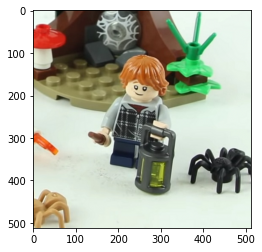

In [12]:
image = cv2.imread('/content/drive/MyDrive/raw_data/harry-potter/0002/009.jpg')
image = cv2.resize(image, (512,512))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0

plt.imshow(image)

In [13]:
index_df = pd.read_csv(dataPath + 'index.csv')
index_df

,path,class_id
0,marvel/0001/001.jpg,1
1,marvel/0001/002.jpg,1
2,marvel/0001/003.jpg,1
3,marvel/0001/004.jpg,1
4,marvel/0001/005.jpg,1
...,...,...
356,star-wars/0016/005.jpg,37
357,star-wars/0016/006.jpg,37
358,star-wars/0016/007.jpg,37
359,star-wars/0016/008.jpg,37


In [14]:
meta_df = pd.read_csv(dataPath + 'metadata.csv')
meta_df

,class_id,lego_ids,lego_names,minifigure_name
0,1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
1,2,[76115],['Spider Mech vs. Venom'],VENOM
2,3,[76115],['Spider Mech vs. Venom'],AUNT MAY
3,4,[76115],['Spider Mech vs. Venom'],GHOST SPIDER
4,5,[75208],"[""Yoda's Hut""]",YODA
5,6,[75208],"[""Yoda's Hut""]",LUKE SKYWALKER
6,7,[75208],"[""Yoda's Hut""]",R2-D2
7,8,[75199],"[""General Grievous' Combat Speeder""]",MACE WINDU
8,9,[75199],"[""General Grievous' Combat Speeder""]",GENERAL GRIEVOUS
9,10,[75264],"[""Kylo Ren's Shuttle Microfighter""]",KYLO REN


In [25]:
df = pd.merge(index_df, meta_df[['class_id', 'minifigure_name']], on='class_id')
df

,path,class_id,minifigure_name
0,marvel/0001/001.jpg,1,SPIDER-MAN
1,marvel/0001/002.jpg,1,SPIDER-MAN
2,marvel/0001/003.jpg,1,SPIDER-MAN
3,marvel/0001/004.jpg,1,SPIDER-MAN
4,marvel/0001/005.jpg,1,SPIDER-MAN
...,...,...,...
356,star-wars/0016/005.jpg,37,OBI-WAN KENOBI
357,star-wars/0016/006.jpg,37,OBI-WAN KENOBI
358,star-wars/0016/007.jpg,37,OBI-WAN KENOBI
359,star-wars/0016/008.jpg,37,OBI-WAN KENOBI


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 0 to 360
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   path             361 non-null    object
 1   class_id         361 non-null    int64 
 2   minifigure_name  361 non-null    object
dtypes: int64(1), object(2)
memory usage: 11.3+ KB


In [27]:
print("Missing Data:",df.isnull().any().any())
df.isnull().sum()

Missing Data: False


path               0
class_id           0
minifigure_name    0
dtype: int64

In [28]:
labels = df['minifigure_name'].unique()
count = df['minifigure_name'].value_counts()

In [19]:
count

SPIDER-MAN                     18
LUKE SKYWALKER                 12
OWEN GRADY                     12
YODA                           12
R2-D2                          12
TRACKER TRAQUEUR RASTREADOR    12
GENERAL GRIEVOUS               12
BLACK WIDOW                    11
YELENA BELOVA                  11
MACE WINDU                     11
RON WEASLEY                    11
TASKMASTER                     11
HARRY POTTER                   11
IRON MAN MK 50                 10
EMPEROR PALPATINE              10
VENOM                          10
AUNT MAY                       10
OUTRIDER 2                     10
CAPTAIN AMERICA                10
IRON MAN MK 5                  10
IRON MAN MK 1                  10
IRON MAN MK 41                 10
GHOST SPIDER                   10
OUTRIDER 1                     10
DARTH VADER                     9
OBI-WAN KENOBI                  9
ANAKIN SKYWALKER                9
FIREFIGHTER                     8
MYSTERIO                        8
KYLO REN      

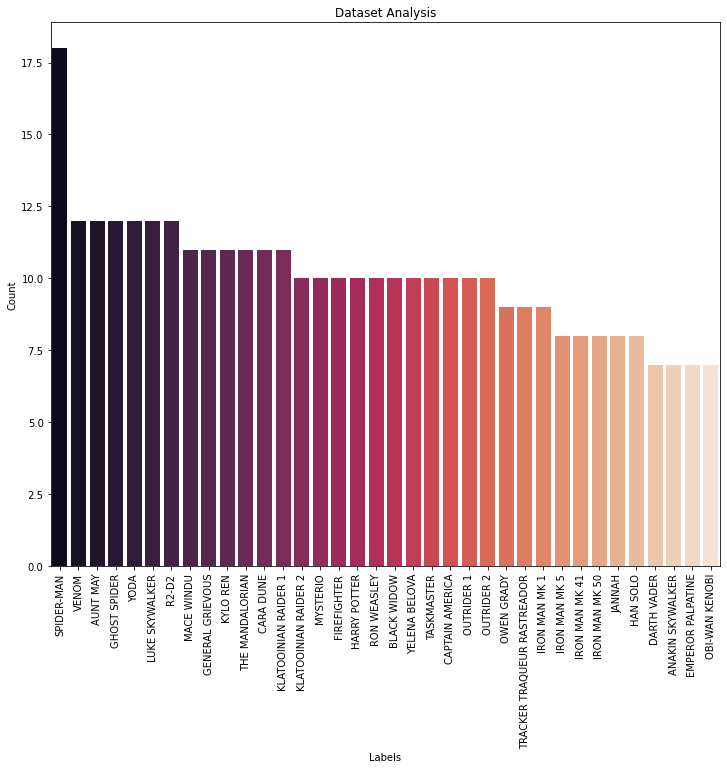

In [29]:
#Visualizing quantity of each minifugure in dataset
import seaborn as sns

plt.figure(figsize=(12,10))
sns.barplot(x=labels, y=count,palette="rocket")

plt.xticks(rotation= 90)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Dataset Analysis')
plt.show()


In [30]:
df_train = pd.DataFrame([])
df_valid = pd.DataFrame([])
for i in range(1,len(df['class_id'].value_counts())+1):

  df_train = df_train.append(df[df['class_id'] == i].iloc[ :-2])
  df_valid = df_valid.append(df[df['class_id'] == i].iloc[-2: ])

In [33]:
len(df_train)

287

In [34]:
len(df_valid)

74

In [35]:
CLASSES = len(df['class_id'].unique())
CLASSES

37

In [50]:
#Training Data Preprocessing

trainData = np.zeros((df_train.shape[0], 224, 224, 3))

for i in range(df_train.shape[0]):
    
    image = cv2.imread('/content/drive/MyDrive/raw_data/' + df_train["path"].values[i])
    
    #Converting BGR to RGB 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    #Resizing image to (224 x 224)
    image = cv2.resize(image, (224,224))
    
    #Normalizing pixel values to [0,1]
    trainData[i] = image / 255.0

trainLabel = np.array(df_train["class_id"])-1

In [51]:
#Validation Data Preprocessing

validData = np.zeros((df_valid.shape[0], 224, 224, 3))

for i in range(df_valid.shape[0]):
    
    image = cv2.imread('/content/drive/MyDrive/raw_data/' + df_valid["path"].values[i])
    
    #Converting BGR to RGB 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    #Resizing image to (224 x 224)
    image = cv2.resize(image, (224,224))
    
    #Normalizing pixel values to [0,1]
    validData[i] = image / 255.0

validLabel = np.array(df_valid["class_id"])-1

In [52]:
trainData, trainLabel

(array([[[[0.37254902, 0.34117647, 0.2745098 ],
          [0.38823529, 0.34901961, 0.28235294],
          [0.38431373, 0.34901961, 0.28235294],
          ...,
          [0.56078431, 0.54901961, 0.48235294],
          [0.56470588, 0.54901961, 0.48235294],
          [0.55686275, 0.54509804, 0.47843137]],
 
         [[0.39215686, 0.36470588, 0.29411765],
          [0.41176471, 0.38431373, 0.31372549],
          [0.41176471, 0.37647059, 0.30980392],
          ...,
          [0.56470588, 0.55294118, 0.48627451],
          [0.57254902, 0.56078431, 0.49411765],
          [0.56862745, 0.55686275, 0.49019608]],
 
         [[0.41960784, 0.39215686, 0.32156863],
          [0.41176471, 0.38431373, 0.31372549],
          [0.40392157, 0.37647059, 0.30588235],
          ...,
          [0.56470588, 0.55294118, 0.48627451],
          [0.58039216, 0.56862745, 0.50196078],
          [0.56862745, 0.55686275, 0.49019608]],
 
         ...,
 
         [[0.30980392, 0.27058824, 0.23529412],
          [0.33725

In [53]:
#Loading Base Model
base_model = MobileNetV2()

#Adding Dropout layer
x = Dropout(0.5)(base_model.layers[-2].output)

#Adding Dense layer
outputs = Dense(CLASSES, activation='softmax')(x)

#Creating model
model = Model(base_model.inputs, outputs)

In [54]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [55]:
model.compile(
    optimizer=Adam(lr=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [63]:
from tensorflow.keras import callbacks
es = callbacks.EarlyStopping(patience=10, monitor='val_accuracy', restore_best_weights=True)

In [64]:
#Training model - 40 epochs
hist = model.fit(
    trainData, trainLabel,
    epochs=40,
    validation_data=(validData, validLabel),
    shuffle=True,
    callbacks=[es],
    batch_size=4
)

Epoch 1/40
72/72 [==============================] - 6s 78ms/step - loss: 0.0229 - accuracy: 0.9965 - val_loss: 0.3199 - val_accuracy: 0.9189
Epoch 2/40
72/72 [==============================] - 5s 74ms/step - loss: 0.0166 - accuracy: 0.9965 - val_loss: 0.3642 - val_accuracy: 0.9324
Epoch 3/40
72/72 [==============================] - 5s 72ms/step - loss: 0.0164 - accuracy: 0.9965 - val_loss: 0.3681 - val_accuracy: 0.8784
Epoch 4/40
72/72 [==============================] - 5s 73ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.2755 - val_accuracy: 0.8919
Epoch 5/40
72/72 [==============================] - 5s 73ms/step - loss: 0.0204 - accuracy: 0.9930 - val_loss: 0.3038 - val_accuracy: 0.9189
Epoch 6/40
72/72 [==============================] - 5s 73ms/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.3210 - val_accuracy: 0.9189
Epoch 7/40
72/72 [==============================] - 5s 73ms/step - loss: 0.0327 - accuracy: 0.9930 - val_loss: 0.3298 - val_accuracy: 0.9054
Epoch 8/40
72

In [66]:
import joblib
joblib.dump(model, 'modelNetV2Final.joblib')

INFO:tensorflow:Assets written to: ram://109ee926-b383-45cf-8208-a8cc6d05b7d9/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


['modelNetV2Final.joblib']

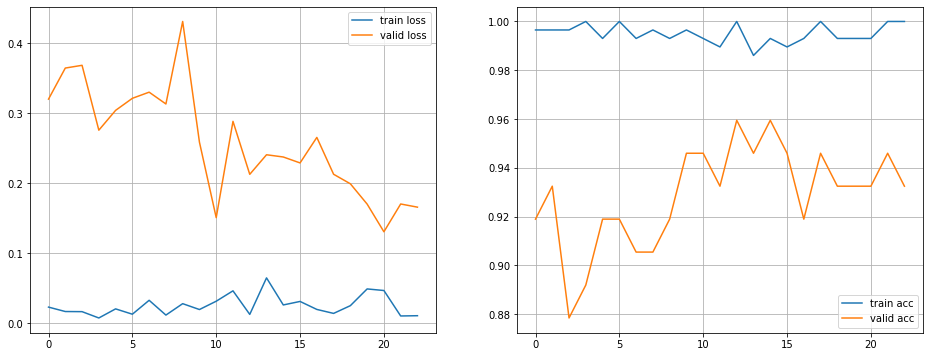

In [65]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='valid loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='train acc')
plt.plot(hist.history['val_accuracy'], label='valid acc')
plt.grid()
plt.legend()

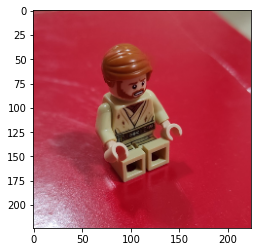

In [84]:
testImage = cv2.imread('/content/drive/MyDrive/raw_data/test/074.jpg')
testImage = cv2.resize(testImage, (224,224))
testImage = cv2.cvtColor(testImage, cv2.COLOR_BGR2RGB) / 255.0

plt.imshow(testImage)

In [85]:
testImage = np.reshape(testImage, (1, 224, 224, 3))

predictedClass = model.predict(testImage).argmax()
predictedClass = predictedClass + 1

figureName = meta_df['minifigure_name'][meta_df['class_id'] == predictedClass].iloc[0]

print(figureName)

OBI-WAN KENOBI
